# 파이토치 RNN 분류 모델
- 코드 출처: https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html

In [173]:
import requests
import zipfile
import io
import os

URL = 'https://download.pytorch.org/tutorial/data.zip'
res = requests.get(URL)
res.raise_for_status()

z = zipfile.ZipFile(io.BytesIO(res.content))

print(z.namelist())

['data/', 'data/eng-fra.txt', 'data/names/', 'data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


In [174]:
z.extractall(os.getcwd())

이름: Ślusàrski

In [175]:
from io import open
import glob

path = os.path.join(os.getcwd(), 'data', 'names')

def find_files(path: str):
    """특정 패턴에 맞는 파일들을 찾아 그 path를 반환하는 함수"""
    return glob.glob(path)

print(find_files(os.path.join(path, '*.txt')))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s: str):
    res = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters) # Accent 제거
    
    return res

print(unicode_to_ascii('Ślusàrski'))

category_lines = {}
all_categories = []

def read_lines(file_name: str):
    lines = open(file_name, encoding='utf-8').read().strip().split('\n')

    return [unicode_to_ascii(line) for line in lines]

for file_name in find_files(os.path.join(path, '*.txt')):
    category = os.path.splitext(os.path.basename(file_name))[0]
    all_categories.append(category)
    lines = read_lines(file_name)
    category_lines[category] = lines
    
n_categories = len(all_categories)

['c:\\Users\\kksoo\\Desktop\\work\\study\\code\\deep_learning\\10.pytorch_gen_nn\\data\\names\\Arabic.txt', 'c:\\Users\\kksoo\\Desktop\\work\\study\\code\\deep_learning\\10.pytorch_gen_nn\\data\\names\\Chinese.txt', 'c:\\Users\\kksoo\\Desktop\\work\\study\\code\\deep_learning\\10.pytorch_gen_nn\\data\\names\\Czech.txt', 'c:\\Users\\kksoo\\Desktop\\work\\study\\code\\deep_learning\\10.pytorch_gen_nn\\data\\names\\Dutch.txt', 'c:\\Users\\kksoo\\Desktop\\work\\study\\code\\deep_learning\\10.pytorch_gen_nn\\data\\names\\English.txt', 'c:\\Users\\kksoo\\Desktop\\work\\study\\code\\deep_learning\\10.pytorch_gen_nn\\data\\names\\French.txt', 'c:\\Users\\kksoo\\Desktop\\work\\study\\code\\deep_learning\\10.pytorch_gen_nn\\data\\names\\German.txt', 'c:\\Users\\kksoo\\Desktop\\work\\study\\code\\deep_learning\\10.pytorch_gen_nn\\data\\names\\Greek.txt', 'c:\\Users\\kksoo\\Desktop\\work\\study\\code\\deep_learning\\10.pytorch_gen_nn\\data\\names\\Irish.txt', 'c:\\Users\\kksoo\\Desktop\\work\\stud

In [176]:
category_lines["Korean"][:5]

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']

In [177]:
import torch

def letter_to_idx(letter: str):
    return all_letters.find(letter)

def letter_to_tensor(letter: str):
    tensor = torch.zeros(1, n_letters) # 배치 크기: 1
    tensor[0][letter_to_idx(letter)] = 1
    
    return tensor

def line_to_tensor(line: str):
    tensor = torch.zeros(len(line), 1, n_letters)

    for i, letter in enumerate(line):
        tensor[i][0][letter_to_idx(letter)] = 1
    
    return tensor

print(letter_to_tensor('J'))
print(line_to_tensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 신경망 생성

- 모델 생성 방법 참고 : https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html

In [178]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input: torch.Tensor, hidden: torch.Tensor):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [179]:
input = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9697, -2.8416, -2.9864, -2.8056, -2.9647, -2.8874, -2.8592, -2.9712,
         -2.8522, -2.8807, -2.8588, -2.8848, -2.9589, -2.9399, -2.8666, -2.8219,
         -2.8949, -2.8116]], grad_fn=<LogSoftmaxBackward0>)


In [180]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9697, -2.8416, -2.9864, -2.8056, -2.9647, -2.8874, -2.8592, -2.9712,
         -2.8522, -2.8807, -2.8588, -2.8848, -2.9589, -2.9399, -2.8666, -2.8219,
         -2.8949, -2.8116]], grad_fn=<LogSoftmaxBackward0>)


## 모델 학습
- 준비

In [181]:
def category_from_output(output: torch.Tensor):
    _, idx = output.topk(1)
    
    return all_categories[idx.item()], idx.item()

print(category_from_output(output))

('Dutch', 3)


In [182]:
import random

def random_choice(l: list):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)

    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print(f"Category: {category}  \t Line: {line}")

Category: Dutch  	 Line: Rooiakkers
Category: French  	 Line: Dufort
Category: Polish  	 Line: Pasternak
Category: French  	 Line: Gage
Category: Japanese  	 Line: Hamamoto
Category: Arabic  	 Line: Bata
Category: Vietnamese  	 Line: Vinh
Category: German  	 Line: Gass
Category: Japanese  	 Line: Nitta
Category: Russian  	 Line: Davitashvili


## 손실함수

In [183]:
criterion = nn.NLLLoss() # 출력 결과가 로그 확률이 되야 함

## 모델 학습

In [184]:
lr = 0.005

def train(category_tensor: torch.Tensor, line_tensor: torch.Tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size(0)):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for param in rnn.parameters():
        param.data.add_(param.grad, alpha=-lr)
    
    return output, loss.item()

In [185]:
import time
import math

n_iters = 300_000
print_every = 5_000
plot_every = 1_000

cur_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s = int(s - m * 60)
    
    return f"{m:d}m {s:d}s"

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    cur_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = 'O' if guess == category else f'X {category:s}'
        print(f"{iter:d} {(iter / n_iters * 100):.2f} ({time_since(start):s}) {loss:.4f} {line:s} / {guess:s} {correct:s}")
    
    if iter % plot_every == 0:
        all_losses.append(cur_loss / plot_every)
        cur_loss = 0

5000 1.67 (0m 3s) 2.3893 Nunes / Dutch X Portuguese
10000 3.33 (0m 7s) 2.1015 Kuipers / Portuguese X Dutch
15000 5.00 (0m 10s) 0.2601 Sakakibara / Japanese O
20000 6.67 (0m 14s) 1.3040 Shu / Vietnamese X Chinese
25000 8.33 (0m 17s) 1.1144 Asfour / Arabic O
30000 10.00 (0m 21s) 1.3849 Fabre / French O
35000 11.67 (0m 24s) 0.5646 Davidson / Scottish O
40000 13.33 (0m 28s) 2.3246 Varey / French X English
45000 15.00 (0m 32s) 1.1778 Gorecki / Czech X Polish
50000 16.67 (0m 35s) 0.0581 Eliopoulos / Greek O
55000 18.33 (0m 39s) 0.3675 Mui / Chinese O
60000 20.00 (0m 42s) 1.9252 Alpin / Scottish X English
65000 21.67 (0m 46s) 0.9889 Amari / Arabic O
70000 23.33 (0m 49s) 3.8232 Pettigrew / Russian X French
75000 25.00 (0m 53s) 1.1391 Jedynak / Czech X Polish
80000 26.67 (0m 56s) 3.8488 Marubeni / Italian X Japanese
85000 28.33 (1m 0s) 0.8363 Salib / Arabic O
90000 30.00 (1m 3s) 0.5375 Hernandez / Spanish O
95000 31.67 (1m 7s) 0.6198 Cai / Chinese O
100000 33.33 (1m 11s) 0.0926 Pefanis / Greek 

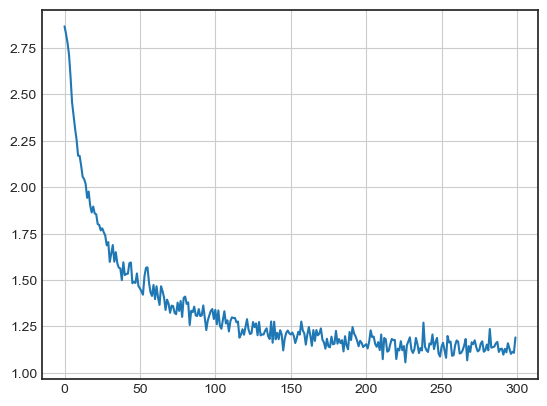

In [186]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

plt.figure()
plt.plot(all_losses)
plt.grid()
plt.show()

## 모델 테스트

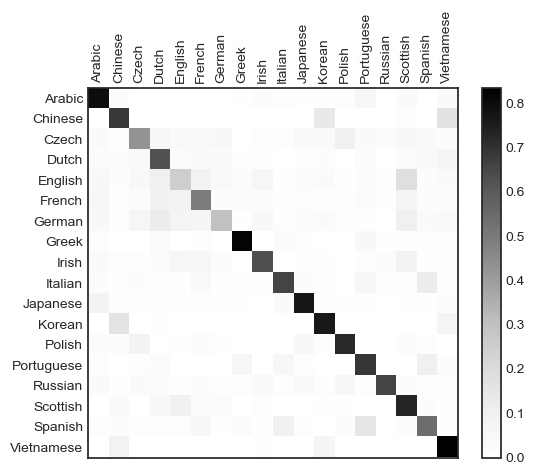

In [190]:
cm = torch.zeros(n_categories, n_categories)
n_confusion = 10_000

def evaluate(line_tensor: torch.Tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size(0)):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    cm[category_i][guess_i] += 1

for i in range(n_categories):
    cm[i] = cm[i] / cm[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm.numpy())
fig.colorbar(cax)
ax.set_xticks(range(n_categories))
ax.set_yticks(range(n_categories))
ax.set_xticklabels(all_categories, rotation=90)
ax.set_yticklabels(all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## 사용자 입력으로부터의 실행

In [192]:
def predict(input_line: torch.Tensor, n_predictions: int=3):
    print(f"\n> {input_line:s}")
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        vals, indices = output.topk(n_predictions, 1, True)
        preds = []
        
        for i in range(n_predictions):
            val = vals[0][i].item()
            idx = indices[0][i].item()
            print(f"{val:.2f} {all_categories[idx]:s}")
            preds.append([vals, all_categories[idx]])

predict("Jackson")
predict("Bill")
predict("Dovesky")
predict("Kim")


> Jackson
-0.06 Scottish
-3.52 English
-4.43 Czech

> Bill
-1.42 English
-1.51 Irish
-2.08 Czech

> Dovesky
-0.62 Russian
-1.11 Czech
-2.64 English

> Kim
-0.38 Korean
-1.92 Vietnamese
-2.00 Chinese
